In [2]:
from comet_ml import Experiment, Optimizer

In [3]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict
from tqdm import trange
import torch
import seaborn as sns
import os
import matplotlib.pyplot as plt
from io import BytesIO
import base64
import time
import datetime

plt.style.use("seaborn")
torch.set_default_dtype(torch.float32)

In [4]:
import node

In [5]:
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score

In [6]:
from tabular_hypernet import Hypernetwork, TrainingModes
from tabular_hypernet.modules import SimpleNetwork
from tabular_hypernet.training_utils import train_slow_step, train_model, train_carthesian
from tabular_hypernet.interfaces import HypernetworkSklearnInterface, SimpleSklearnInterface

In [73]:
from benchmark_utils import show_fractions

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/blastchar-hypernet/be4662246a1b4a5a955bb6a7a5e4d3f9
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [254495] : (0.035909686237573624, 1.4508302211761475)
COMET INFO:   Parameters:
COMET INFO:     copy      : True
COMET INFO:     data_size : 5948
COMET INFO:     epochs    : 50
COMET INFO:     mask_size : 5
COMET INFO:     masks_no  : 50
COMET INFO:     with_mean : True
COMET INFO:     with_std  : True
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (859.60 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     model graph              : 1
COMET INFO:     notebo

In [7]:
from loguru import logger

logger.add("log.txt", format='{time:YYYY-MM-DD HH:mm:ss.SSS} | {message}')

1

In [8]:
DEVICE = 'cuda:1'

## Load data

In [121]:
data = pd.read_csv("../data/Blastchar/churn.csv")

In [123]:
processed_data = data.copy()
del processed_data["customerID"]
processed_data = processed_data[processed_data['TotalCharges'] != " "]
processed_data['TotalCharges'] = pd.to_numeric(processed_data['TotalCharges'])

y_label_enc = LabelEncoder()
y = y_label_enc.fit_transform(processed_data["Churn"].values)
del processed_data["Churn"]

show_fractions(y)

0 samples: 5163 (73.4%)
1 samples: 1869 (26.6%)


### Preprocess features

In [124]:
label_encoders = {}
for col in processed_data.columns:
    if processed_data[col].dtype == 'object':
        encoder = LabelEncoder()
        processed_data[col] = encoder.fit_transform(processed_data[col].values)
        label_encoders[col] = encoder
        
X = processed_data.values
print(X.shape)

(7032, 19)


### Split it into train and test set

In [126]:
import imblearn

## Preprocess

In [127]:
np.random.seed(42)

def prepare_data(X, y, size=None):
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=size)
    X_train, y_train = imblearn.over_sampling.RandomOverSampler(random_state=42).fit_resample(X_train, y_train)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    X_train, X_test, y_train, y_test = [torch.from_numpy(x) for x in [X_train, X_test, y_train, y_test]]
    
    return X_train, X_test, y_train, y_test

In [128]:
X_train, X_test, y_train, y_test = prepare_data(X, y, size=100)

print("Training data:")
show_fractions(y_train)

print("Test data:")
show_fractions(y_test)

Training data:
0 samples: 67 (50.0%)
1 samples: 67 (50.0%)
Test data:
0 samples: 5096 (73.5%)
1 samples: 1836 (26.5%)


## Benchmark

In [ ]:
criterion = torch.nn.CrossEntropyLoss()

### XGBoost

In [130]:
from xgboost import XGBClassifier

torch.Size([7756, 19])
1
2
3
4
5
6
7
8
9
10


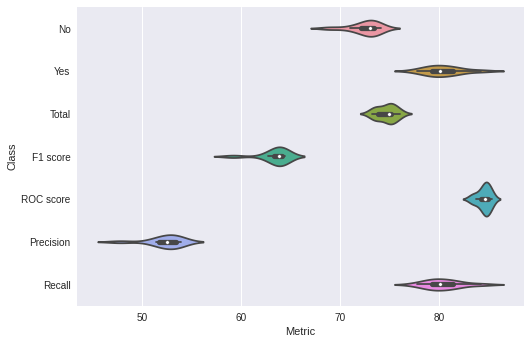

In [134]:
def get_xgboost():
    random_seed = np.random.randint(1024)
    return XGBClassifier(
        verbosity=0,
        random_state=random_seed,
        subsample=0.98,
        use_label_encoder=False)

xgb_dframe = test_model(get_xgboost, 
                        (X, y),
                        label_encoder=y_label_enc, iters=10)

In [135]:
print_statistics(xgb_dframe)

F1: 63.334 ~ 1.538
C-statistics: 84.489 ~ 0.647
Precision: 52.265 ~ 1.796
Recall: 80.412 ~ 1.826


### Neural network

In [144]:
def simple_network_fn(epochs):
    def _inner():
#         net = SimpleNetwork(X_train.shape[1], outputs=2).to(DEVICE)
        net = torch.nn.Sequential(
            torch.nn.Dropout(1-5/19),
            torch.nn.Linear(X_train.shape[1], 100),
            torch.nn.ReLU(),
            torch.nn.Dropout(0.5),
            torch.nn.Linear(100, 2)
        ).to(DEVICE)
        return SimpleSklearnInterface(net, device=DEVICE, epochs=epochs, batch_size=32)
    return _inner

torch.Size([5956, 19])
1
2
3
4


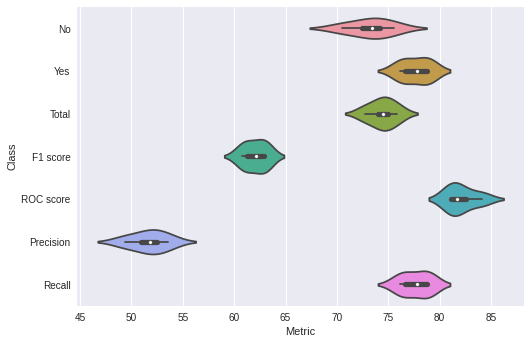

In [146]:
simple_nn_results = test_model(simple_network_fn(50),
                (X, y),
                y_label_enc, 4, data_size=4000)

In [147]:
print_statistics(simple_nn_results)

F1: 62.019 ~ 1.123
C-statistics: 82.112 ~ 1.402
Precision: 51.662 ~ 1.753
Recall: 77.642 ~ 1.397


### NODE

In [ ]:
from qhoptim.pyt import QHAdam

In [ ]:
def node_fn(layer_dims):
    def _inner():
        network = torch.nn.Sequential(
            node.DenseBlock(X_train.shape[1], layer_dims, num_layers=1, tree_dim=2, depth=6, flatten_output=False,
                           choice_function=node.entmax15, bin_function=node.entmoid15),
            node.Lambda(lambda x: x.mean(dim=1))
        )
        
        with torch.no_grad():
            res = network(torch.as_tensor(X_train[:1000], device='cpu').to(torch.float32))
        
        network = network.to(DEVICE)
        network.device=DEVICE
            
        optimizer_params = { 'nus':(0.7, 1.0), 'betas':(0.95, 0.998) }
        optim = QHAdam(network.parameters(), **optimizer_params)
            
        network = SimpleSklearnInterface(network, device=DEVICE, epochs=150, batch_size=32)
        network.optimizer = optim
        return network
    return _inner

In [ ]:
%%capture --no-stdout

node_results = test_model(node_fn(128),
                (X, y),
                y_label_enc, 4, data_size=4000)

In [22]:
print_statistics(node_results)

NameError: name 'node_results' is not defined

torch.Size([7784, 19])

### Hypernetwork

In [143]:
def network_fn(epochs=10, mask_size=15, test_nodes=15):
    def _inner():
        network = Hypernetwork(inp_size=X_train.shape[1], 
                            out_size=y.max().item()+1, 
                            mask_size=mask_size,
                            layers=[128, 128, 128],
                            node_hidden_size=100, 
                            mode=TrainingModes.CARTHESIAN,
                            test_nodes=test_nodes, device=DEVICE).to(DEVICE)

        network = HypernetworkSklearnInterface(network, device=DEVICE, epochs=epochs, batch_size=32)
        return network
    return _inner

In [140]:
def figure_to_html():
    tmpfile = BytesIO()
    plt.gcf().savefig(tmpfile, format='png')
    encoded = base64.b64encode(tmpfile.getvalue()).decode('utf-8')

    html = '<img src=\'data:image/png;base64,{}\'>'.format(encoded)
    return html

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/blastchar-hypernet/35e981470a254c9a914e298f82834f96
COMET INFO:   Metrics [count] (min, max):
COMET INFO:     loss [93150] : (0.0556909516453743, 1.5526331663131714)
COMET INFO:   Parameters:
COMET INFO:     base_score        : 0.5
COMET INFO:     begin_iteration   : 0
COMET INFO:     booster           : gbtree
COMET INFO:     colsample_bylevel : 1
COMET INFO:     colsample_bytree  : 1
COMET INFO:     copy              : True
COMET INFO:     data_size         : 1446
COMET INFO:     end_iteration     : 100
COMET INFO:     epochs            : 100
COMET INFO:     feature_names     : ['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18']
COMET INFO:     gamma             :

torch.Size([1430, 19])
1
TrainingModes.CARTHESIAN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.52s/it]


2
TrainingModes.CARTHESIAN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:31<00:00,  9.13s/it]


3
TrainingModes.CARTHESIAN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:23<00:00,  8.38s/it]


4
TrainingModes.CARTHESIAN


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [01:25<00:00,  8.56s/it]


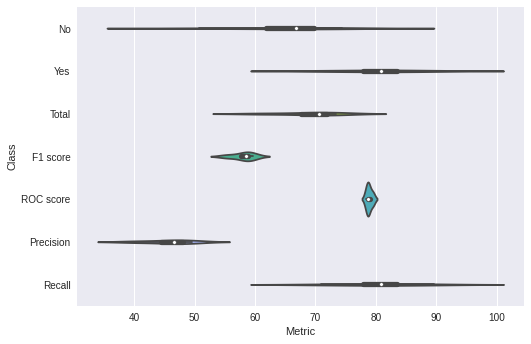

In [141]:
epochs = 100
mask_size = 5
masks_no = 50
X_train, X_test, y_train, y_test = prepare_data(X, y, 1000)
data_size = X_train.shape[0]

exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")
exp.log_parameters({"epochs": epochs, "mask_size": 5, "masks_no": 50, "data_size": data_size})
exp.add_tag("blastchar-benchmark")

nn_results = test_model(network_fn(epochs, 5, 50),
                (X, y),
                y_label_enc, 4, data_size=100)

# exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
# exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

In [142]:
print_statistics(nn_results)

F1: 58.020 ~ 1.809
C-statistics: 78.869 ~ 0.459
Precision: 45.767 ~ 4.063
Recall: 80.496 ~ 7.647


In [ ]:
mask_size = 5
total = 15
current = 0

res = {}
for epochs in [100, 150, 200, 300, 500]:
    for masks_no in [50, 30, 70]:
        current += 1
        description = f"{epochs=}, {mask_size=}, {masks_no=}"
        exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")

        nn_results = test_model(network_fn(epochs, mask_size, masks_no),
                        (X, y),
                        y_label_enc, 4, data_size=100)

        exp.log_parameters({"epochs": epochs, "mask_size": mask_size, "masks_no": masks_no})
        exp.add_tag("hypernet-full-optim")
        exp.log_table("metrics.csv", nn_results.groupby("Class").mean())
        exp.log_metric("f1_score", nn_results.groupby("Class").mean().loc["F1 score"])

        res[description] = nn_results
        logger.info(description)
        logger.info(f"{current}/{total}")
        print_statistics(res[description])

In [70]:
for key in res.keys():
    print(key)
    print_statistics(res[key])

epochs=100, mask_size=5, masks_no=50
F1: 60.890 ~ 1.154
C-statistics: 83.136 ~ 0.376
Precision: 53.227 ~ 5.449
Recall: 72.538 ~ 8.134
epochs=100, mask_size=5, masks_no=30
F1: 60.464 ~ 1.268
C-statistics: 82.603 ~ 0.516
Precision: 49.242 ~ 4.728
Recall: 79.565 ~ 7.094
epochs=100, mask_size=5, masks_no=70
F1: 49.704 ~ 10.204
C-statistics: 82.516 ~ 1.119
Precision: 65.107 ~ 6.064
Recall: 43.269 ~ 17.677


In [66]:
exp.run_id

'RKwbRoPWKvsMjkjK3JobL0J5e'

#### Hyperparameter optimizations

In [59]:
X_train, X_test, y_train, y_test = prepare_data(X, y)

hypernet = network_fn(150, 5, 50)()
train_carthesian(hypernet.network,
                hypernet.optimizer,
                hypernet.criterion,
                (get_dataloader(X_train, y_train, batch_size=batch_size),
                 get_dataloader(X_test, y_test, batch_size=64)),
                X_train.shape[0],
                150,
                50,
                "carthesian-blastchar", device=DEVICE, test_every=5)

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/hypernetwork/2f2240ba58c34d798b713d7a10cca508

  4%|█████▊                                                                                                                                           | 6/150 [02:30<1:00:08, 25.06s/it, loss=0.533, test_acc=73.4]


KeyboardInterrupt: 

In [31]:
(y_pred==y_test.numpy()).mean()

0.740488358886996

In [30]:
from tabular_hypernet.training_utils import train_slow_step
hypernet_res = []
for batch_size in [4, 8, 16, 32, 64]:
    start = time.time()

    exp = Experiment(os.environ.get("COMET_KEY"), "blastchar-hypernet")
    exp.log_parameters({"batch_size": batch_size})
    # nn_results = test_model(network_fn(batch_size),
    #                         (X_train, y_train), 
    #                         (X_test, y_test), 
    #                         y_label_enc, 1)

    hypernet = network_fn(batch_size)()
    train_carthesian(hypernet.network,
                    hypernet.optimizer,
                    hypernet.criterion,
                    (get_dataloader(X_train, y_train, batch_size=batch_size),
                     get_dataloader(X_test, y_test, batch_size=64)),
                    X_train.shape[0],
                    1500,
                    15,
                    exp, device=DEVICE, test_every=50)
                    
                    
    nn_results["Batch size"] = batch_size
    plt.title(f"Batch size: {batch_size}")

    loss = nn_results[nn_results["Class"]=="Loss"]["Accuracy"]
    accuracy = nn_results[nn_results["Class"]=="Total"]["Accuracy"]
    exp.log_metric("mean_loss", loss.mean())
    exp.log_metric("loss_std", loss.std())
    exp.log_metric("mean_acc", accuracy.mean())
    exp.log_metric("acc_std", accuracy.std())

    exp.log_dataframe_profile(nn_results)
    exp.log_html(figure_to_html())
    plt.show()

    hypernet_res.append(nn_results)

    end = datetime.timedelta(seconds=time.time()-start)
    logger.info(f"{batch_size=} done in {str(end)}. Loss: {loss.mean():.3g}+-{loss.std():.3g}. Acc: {accuracy.mean():.1f}+-{accuracy.std():.2f}")

COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.ml https://www.comet.ml/wwydmanski/blastchar-hypernet/3edb7f6be6b04865ba9197e471dc32a6

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/wwydmanski/blastchar-hypernet/3edb7f6be6b04865ba9197e471dc32a6
COMET INFO:   Parameters:
COMET INFO:     batch_size : 32
COMET INFO:   Uploads:
COMET INFO:     environment details      : 1
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (856.46 KB)
COMET INFO:     installed packages       : 1
COMET INFO:     notebook                 : 1
COMET INFO:     os packages   

KeyboardInterrupt: 

### TabNet

In [ ]:
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor

In [149]:
np.array(X_train).shape

(134, 19)

Device used : cuda
No early stopping will be performed, last training weights will be used.
epoch 0  | loss: 0.84536 |  0:00:00s
epoch 1  | loss: 0.70384 |  0:00:00s
epoch 2  | loss: 0.62857 |  0:00:00s
epoch 3  | loss: 0.5942  |  0:00:00s
epoch 4  | loss: 0.59312 |  0:00:00s
epoch 5  | loss: 0.54083 |  0:00:00s
epoch 6  | loss: 0.52085 |  0:00:00s
epoch 7  | loss: 0.50849 |  0:00:00s
epoch 8  | loss: 0.50789 |  0:00:00s
epoch 9  | loss: 0.47963 |  0:00:00s
epoch 10 | loss: 0.4389  |  0:00:00s
epoch 11 | loss: 0.43232 |  0:00:00s
epoch 12 | loss: 0.40346 |  0:00:00s
epoch 13 | loss: 0.3868  |  0:00:00s
epoch 14 | loss: 0.40405 |  0:00:00s
epoch 15 | loss: 0.39284 |  0:00:00s
epoch 16 | loss: 0.39727 |  0:00:00s
epoch 17 | loss: 0.36165 |  0:00:00s
epoch 18 | loss: 0.38959 |  0:00:00s
epoch 19 | loss: 0.40563 |  0:00:00s
epoch 20 | loss: 0.40416 |  0:00:00s
epoch 21 | loss: 0.31999 |  0:00:00s
epoch 22 | loss: 0.3385  |  0:00:00s
epoch 23 | loss: 0.32313 |  0:00:00s
epoch 24 | loss: 0.3

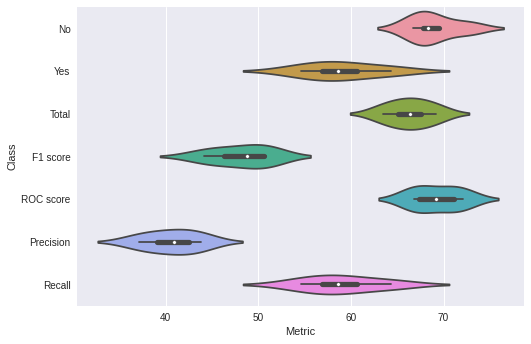

In [150]:
def tabnet_fn():
    clf = TabNetClassifier(seed=np.random.randint(1024))
    return clf

tabnet_results = test_model(tabnet_fn,
                    (np.array(X_train), np.array(y_train)), 
                    (X_test, y_test),
                    y_label_enc, 4)

In [151]:
print_statistics(tabnet_results)

F1: 48.135 ~ 3.153
C-statistics: 69.298 ~ 2.537
Precision: 40.670 ~ 2.924
Recall: 59.028 ~ 4.102


/tmp/ipykernel_276146/3812846823.py:66: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="F1 score"].mean(), dframe[dframe["Class"]=="F1 score"].std()
/tmp/ipykernel_276146/3812846823.py:69: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]=="ROC score"].mean(), dframe[dframe["Class"]=="ROC score"].std()
/tmp/ipykernel_276146/3812846823.py:72: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mean, std = dframe[dframe["Class"]